# __Predicting Airbnb Unlisting__ <img align='right' width='150' height='150' src='https://maiseducativa.com/wp-content/uploads/2015/02/Logo_Nova-IMS.jpg'>

## <font color='SeaGreen'>__Text Mining__</font><br>

> __Group 47__ composed by:
>> __Daniel Franco, nº20210719__ <p>
>> __João Malho, nº20220696__ <p>
>> __Mahmoud Ahmed, nº202213978__ <p>
>> __Taher Ben Slama, nº20221039__ <p>

***

## __Introduction__

__Your solution should present the following points:__

__1. Data Exploration (1.5 points):__

Here you should analyze the corpora and provide some conclusions and visual information (bar charts, word clouds, etc.) that contextualize the data.

__2. Data Preprocessing (2 points):__

You must apply a method to split your training corpus into train/validation sets to evaluate the performance of your model (you can also resort to KFold cross validation, or other methods). Moreover, you must correctly implement and experiment at least four (4) of the data preprocessing techniques shown in class (stop words, regular expressions, lemmatization, stemming, etc.).

__3. Feature Engineering (5 points):__

You must correctly implement and experiment with two (2) of the feature engineering techniques seen in class (TF-IDF, GloVe embeddings, etc.).

__4. Classification Models (4.5 points):__

You must correctly implement and test three (3) of the classification algorithms seen in class (KNN, LR, MLP, LSTM, etc.). 

__5. Evaluation (1.5 points):__

You must evaluate your models resorting, at least, to Recall, Precision, Accuracy and F1-Score.
Moreover, the development of extra work (more techniques than the minimum required in the previous points and/or techniques not shown in class) is highly recommended and will account for a maximum of 4.5 points divided as follows:
    
>__1. Data Preprocessing__ – 0.25 points for each extra method (unseen in class) used (maximum of 2 extra methods).

>__2. Feature Engineering__ – 1 point for each extra method using Transformed-based embeddings (maximum of 2 extra methods)

>__3. Classification Models__ – 1 point for each extra


## 📖 __Data__

__The data is divided in following sets:__

* __Train (train.xlsx) (12,496 lines):__

> Contains the Airbnb and host descriptions (“description” and “host_about” columns), as well as the information regarding the property listing status (“unlisted” column). A property is considered unlisted (1) if it got removed from the quarterly Airbnb list and it is considered listed (1) if it remains on that same list.

* __Train Reviews (train_reviews.xlsx) (72,1402):__ 

> This file has all the guests’ comments made to each Airbnb property. Note that there can be more than one comment per property, not all properties have comments, and comments can appear in many languages!

* __Test (test.xlsx) (1,389 lines):__

> The structure of this dataset is the same as the train set, except that it does not contain the “unlisted” column. The teaching team is keeping this information secret! You are expected to provide the predicted status (0 or 1) for each Airbnb in this set. Once the projects are delivered, we will compare your predictions with the actual (true) labels.

* __Test Reviews (test_reviews.xlsx) (80,877):__ 

> The structure of this dataset is the same as the train reviews set, but the comments correspond to the properties present on the test set

***



### __1. Libraries and Data import__

In [155]:
#!pip install wordcloud
#!pip install langdetect
#!pip install googletrans
#!pip install emot
#!pip install emoji == 1.7
#!pip install translate
#!pip install gensim
#!pip install transformers
#!pip install keras
#!pip install tensorflow
#!pip install xgboost

import os
import re
import keras
import torch
import emoji
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import urllib.request
import xgboost as xgb
from sklearn import metrics
from langdetect import detect
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.corpus import stopwords
import plotly.graph_objects as go
from gensim.models import FastText
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neural_network import MLPClassifier
from transformers import BertTokenizer, BertModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, auc

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

warnings.filterwarnings('ignore')

In [4]:
current_directory = os.getcwd()

corpora_test = pd.read_excel(os.path.join(current_directory, 'test.xlsx'), index_col=0)
corpora_train = pd.read_excel(os.path.join(current_directory, 'train.xlsx'), index_col=0)
corpora_test_review = pd.read_excel(os.path.join(current_directory, 'test_reviews.xlsx'), index_col=0)
corpora_train_review = pd.read_excel(os.path.join(current_directory, 'train_reviews.xlsx'), index_col=0)


## 1. Data Exploration 
* data presentation and explanation of the main finding from the exploratory analysis (accounts for 50% of criteria 4.1).

* Analyze the provided datasets to understand their structure, size, and content.  <br>
* Explore the distribution of the target variable "unlisted" in the training dataset with visualizations. <br>
* Analyze the text data in the "description" and "host_about" columns to identify patterns, word frequencies, and language diversity. <br>
* Generate word clouds to visualize the most common words in the descriptions and comments. <br>

In [5]:
def missing_value_reporter(data, threshold=None):

    na_count = data.isna().sum() 
    na_count = na_count[na_count > 0]
    na_abs_frq = na_count.values
    na_rel_frq = round(na_count/len(data),2)
    missings = pd.DataFrame({'Feature': na_count.index, 'Nº of missings': na_abs_frq, '% of missings': na_rel_frq})
    missings = missings.sort_values(by = 'Nº of missings', ascending = False)
    
    if threshold:
        missings['Above threshold'] = [True if x > threshold else False for x in missings['% of missings']]
        
    return missings

### 1.1 Analyze the provided datasets to understand their structure, size, and content

> __Train sets__


In [6]:
corpora_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [7]:
corpora_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12496 entries, 1 to 12496
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  12496 non-null  object
 1   host_about   12496 non-null  object
 2   unlisted     12496 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 390.5+ KB


__Notes:__ 

1. Each row represents a different Airbnb
2. For each Airbnb there's a description of the installations and host
3. Also there's a binary column that shows if the Airbnb was unlisted or not (target)
4. It seems that there's no missing values "12496 non-null of 12496 entries/rows" for all columns
5. It's observable multiple languages in the dataset

In [8]:
corpora_train_review.head()

,comments
index,
1,this is a very cozy and comfortable house to s...
1,good<br/>
1,"My first hostel experience, and all I have to ..."
1,Das Hostel war neu und deshalb funktionierte a...
1,"It was fine for a dorm, but I think for the pe..."


In [9]:
corpora_train_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721402 entries, 1 to 12494
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   comments  721398 non-null  object
dtypes: object(1)
memory usage: 11.0+ MB


In [10]:
missing_value_reporter(corpora_train_review)

,Feature,Nº of missings,% of missings
comments,comments,4,0.0


__Notes:__ 

1. Each row represents a different review (comments) for a specific Airbnb in index 
2. Comments columns seems to have 4 missing values "721398 non-null of 721402 entries/rows" but it's a really low percentage so this missing values can be dropped
3. It's observable multiple languages in the dataset

> __Test sets__

In [11]:
corpora_test.head()

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [12]:
corpora_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1389 entries, 1 to 1389
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  1389 non-null   object
 1   host_about   1389 non-null   object
dtypes: object(2)
memory usage: 32.6+ KB


__Notes:__ 

1. Same structure as "corpora_train" but without target (unlisted)
2. Seem to have no missing values "1389 non-null of 1389 entries/rows" for both columns

In [13]:
corpora_test_review.head()

,comments
index,
1,Thank you very much Antonio ! All has been per...
1,Very nice appartment in the old town of Lissab...
1,When travelling we're looking for kids friendl...
1,We've been in Lisbon in march 2013 (3 adults a...
1,Our host Antonio was very helpful with informa...


In [14]:
corpora_test_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80877 entries, 1 to 1388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  80877 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


__Notes:__ 

1. Same structure as "corpora_train_review"
2. Seem to have no missing values "80877 non-null of 80877 entries/rows" for both columns

__After data analysis can be noted that:__

> File `corpora_train_review`:
__Features__:

1. __[index]__ - (Int) Index correspondency with Index in file `corpora_train`
2. __[comments]__ - (Str) Each comment per line


> File `corpora_test_review`:
__Features__:

1. __[index]__ - (Int) Index correspondency with Index in file `corpora_test`
2. __[comments]__ - (Str) Each comment per line


> File `corpora_train`:
__Features__:

1. __[index]__ - (Int) Index correspondency
2. __[description]__ - (Str) Description of the asset
3. __[host_about]__ - (Str) Description of the asset host
4. __[unlisted]__ - (Bool) Is asset unlisted or not 

> File `corpora_test`:
__Features__:

1. __[index]__ - (Int) Index correspondency
2. __[description]__ - (Str) Description of the asset
3. __[host_about]__ - (Str) Description of the asset host


Is also noted that train data is not balanced, model will be train with ~28% of unlisted individuals.

Our data contains several languages as well were the majority is 81,6% of English although there are more.

Is notable the existence of 4 missing values that were dropped due the residual impact.

### 1.2 Explore the distribution of the target variable "unlisted" 

In [15]:
# Calculate the percentage for each category
total = len(corpora_train)
corpora_train_counts = corpora_train['unlisted'].value_counts()
corpora_train_percentages = 100 * corpora_train_counts / total

class_weight = corpora_train_percentages.copy()

# Create the horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        y=corpora_train_percentages.index,
        x=corpora_train_percentages.values,
        orientation='h',
        marker=dict(color='rgb(121, 157, 196)')
    )
])

# Add percentage labels to each bar
for i, percentage in enumerate(corpora_train_percentages.values):
    fig.add_annotation(
        x=percentage + 2,
        y=corpora_train_percentages.index[i],
        text=f'{percentage:.1f}%',
        showarrow=False,
        font=dict(size=12, color='black')
    )

# Set the layout
fig.update_layout(
    title='Count of Unlisted',
    xaxis_title='Percentage',
    yaxis_title='Unlisted',
    yaxis=dict(autorange="reversed"),
    height=400,
    width=800,
    margin=dict(l=100, r=20, t=60, b=20)
)

# Show the plot
fig.show()


__Notes:__

1. Binary classification problem where the train data is not balanced, model will be train with ~28% of unlisted individuals if the data is stratified

### 1.3 Language diversity

> Language diversity
>>  Description

In [16]:
# detect language
def detect_textlang(text):
    try:
        src_lang = detect(text)
        if src_lang =='en':
            return 'en'
        else:
            return src_lang
    except:
        return "NA"
    
# creating new column with language sufixes
corpora_train['desc_language']=corpora_train.description.apply(detect_textlang)

corpora_train['host_language']=corpora_train.host_about.apply(detect_textlang)

In [17]:
# Calculate the percentage for each category
total = len(corpora_train)
corpora_train_counts = corpora_train['desc_language'].value_counts()
corpora_train_percentages = 100 * corpora_train_counts / total

# Create the horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        y=corpora_train_percentages.index,
        x=corpora_train_percentages.values,
        orientation='h',
        marker=dict(color='rgb(121, 157, 196)')
    )
])

# Add percentage labels to each bar
for i, percentage in enumerate(corpora_train_percentages.values):
    fig.add_annotation(
        x=percentage + 2,
        y=corpora_train_percentages.index[i],
        text=f'{percentage:.1f}%',
        showarrow=False,
        font=dict(size=12, color='black')
    )

# Set the layout
fig.update_layout(
    title='Description Languages in Train',
    xaxis_title='Percentage',
    yaxis_title='Language',
    yaxis=dict(autorange="reversed"),
    height=400,
    width=800,
    margin=dict(l=100, r=20, t=60, b=20)
)

# Show the plot
fig.show()

> Language diversity
>> Comments

In [18]:
# creating new column with language sufixes
corpora_train_review['language']=corpora_train_review.comments.apply(detect_textlang)

In [19]:
# Calculate the percentage for each category
total = len(corpora_train_review)
corpora_train_counts = corpora_train_review['language'].value_counts()
corpora_train_percentages = 100 * corpora_train_counts / total

# Create the horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        y=corpora_train_percentages.index,
        x=corpora_train_percentages.values,
        orientation='h',
        marker=dict(color='rgb(121, 157, 196)')
    )
])

# Add percentage labels to each bar
for i, percentage in enumerate(corpora_train_percentages.values):
    fig.add_annotation(
        x=percentage + 2,
        y=corpora_train_percentages.index[i],
        text=f'{percentage:.1f}%',
        showarrow=False,
        font=dict(size=7, color='black')
    )

# Set the layout
fig.update_layout(
    title='Languages in Train Reviews',
    xaxis_title='Percentage',
    yaxis_title='Language',
    yaxis=dict(
        autorange="reversed",
        tickfont=dict(size=7)  # Set the font size for y-axis tick labels
    ),
    height=400,
    width=800,
    margin=dict(l=100, r=20, t=60, b=20)
)


# Show the plot
fig.show()

### 1.4 Emojis count

In [20]:
def emoji_count_text(text_column):
    emoji_sum = 0
    emoji_lines = []
    for i, text in enumerate(text_column):
        if isinstance(text, str):
            emoji_count = emoji.emoji_count(text, unique=False)
            if emoji_count > 0:
                emoji_sum += emoji_count
                emoji_lines.append(i)
    return emoji_sum, emoji_lines

emojis_train, emoji_lines_train = emoji_count_text(corpora_train['description'])
emojis_test, emoji_lines_test = emoji_count_text(corpora_test['description'])
emojis_test_review, emoji_lines_test_review = emoji_count_text(corpora_test_review['comments'])
emojis_train_review, emoji_lines_train_review = emoji_count_text(corpora_train_review['comments'])

categories = ['Train Description', 'Test Description', 'Test Reviews', 'Train Reviews']
emoji_counts = [emojis_train, emojis_test, emojis_test_review, emojis_train_review]

fig = go.Figure(data=[go.Bar(x=categories, y=emoji_counts)])
fig.update_layout(title='Emoji Count', xaxis_title='Dataset', yaxis_title='Count')
fig.show()

In [106]:
def get_distinct_emojis(textcolumn):
    emojis = []
    for text in textcolumn:
        if isinstance(text, str):
            emojis += re.findall(emoji.get_emoji_regexp(), text)

    distinct_emojis = list(set(emojis))
    print('Distinct emojis \n {}:'.format(distinct_emojis), end='\n\n')

print('In Airbnb train description:')
get_distinct_emojis(corpora_train['description'])
print('In Airbnb test description:')
get_distinct_emojis(corpora_test['description'])
print('In Airbnb train comments:')
get_distinct_emojis(corpora_train_review['comments'])

Distinct emojis 
 ['💯', '➡', '⭐', '🐕', '😎', '®', '🤗', '🥳', '🐶', '🖤', '♥', '🚭', '😷', '✔️', '😉', '🌉', '☝', '😶', '🚇', '📍', '☀️', '💙', '🙌', '🏖️', '⚠️', '🚕', '😂', '💓', '🚗', '↗', '😀', '☀', '❤️', '✈️', '🌴', '📡', '🚙', '✔', '☑️', '➡️', '▪', '❤', '✅', '☺', '🙂', '😊', '🌿', '⛱️', '🏡']:
Distinct emojis 
 ['💙', '♥', '✔', '⭐', '🌷', '✨', '😄', '🌿', '🎉', '😊', '😘', '☝', '❤️', '🤟🏽']:
Distinct emojis 
 ['👼', '🍞', '👯\u200d♀️', '💩', '🚃', '🇷🇴', '🐰', '🚲', '💎', '🇫🇮', '🏵', '💜', '💥', '🎻', '✌🏾', '👏🏽', '🤦🏼\u200d♀️', '🧚🏻\u200d♂️', '💙', '🇧🇷', '🦭', '😅', '🚵\u200d♀️', '🫶🏿', '👫', '🧘', '🍳', '🛍', '🌿', '🧗\u200d♀️', '⛱', '👩\u200d💻', '🌼', '❣', '🔥', '😢', '🐱', '🙈', '👌🏼', '🥰', '✌🏽', '🥐', '🇧🇪', '🌳', '👆🏼', '😬', '🔴', '🙋🏼\u200d♀️', '💟', '😲', '🚶🏽\u200d♀️', '🤞🏽', '😺', '🚗', '👍🏿', '🍰', '😤', '🦏', '🤷\u200d♂️', '🚊', '‼', '‼️', '📞', '🌝', '⛱️', '✌️', '😮', '😑', '🇺🇸', '🎤', '🇩🇰', '🤭', '🎇', '🇬🇧', '🇨🇴', '🖖', '👪', '😪', '😱', '🤙🏾', '🎨', '⛵', '➕', '🐣', '🐲', '☀️', '🏴\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f', '🧐', '🎏', '👎', '🔋', '©',

### 1.5 Basic Preprocess

__Basic preprocess (not the final) consists on:__

* __Lowercase text__
> Converting everything to lowercase reducing vocabulary size

* __Remove Numerical Data and Punctuation__
> Normalize Dates and Numbers

* __Remove Stop Words__
> Removing words that are not very informative. Less tokens same meaning.

* __Lemmatize__
> Turning words into their root word

* __Stemmer__
> Remove last few characters to obtain the shorter form of each word, this one is setted to False in order to not perform.

In [21]:
# Data Pre Processing
stop = set(stopwords.words('english'))

def pre_process(text_list, lemmatize, stemmer):
    
    updates = []
    
    for j in tqdm(text_list):
        
        if isinstance(j, str):

            text = j
            
            # Lowercase text
            text = text.lower()
            
            # Remove tags
            text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
            
            # Remove special characters and digits
            text = re.sub("[^a-zA-Z]", " ", text)
            text = re.sub("(\\d|\\W)+", " ", text)
            text = re.sub('[0-9]+', '', text)

            # removes HTML 
            text = re.sub(r'http\S+', '',text)

            # removing lefotvers of html
            text = re.sub(r'br', '',text)
            text = re.sub(r'b', '',text)


            # Remove stopwords
            text = " ".join([word for word in text.split() if word not in stop])

        else:
            text = ""
            
        
        # Lemmatize
        if lemmatize:
            lemma = WordNetLemmatizer()
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # Stemming
        if stemmer:
            stemmer = SnowballStemmer('english')
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [22]:
# Data Pre Processing on description saved in a list
clean_description = pre_process(corpora_train['description'], lemmatize=True, stemmer=False)

100%|██████████| 12496/12496 [00:03<00:00, 3467.06it/s]


In [23]:
# host about
clean_host = pre_process(corpora_train['host_about'], lemmatize=True, stemmer=False)

100%|██████████| 12496/12496 [00:01<00:00, 7081.69it/s]


In [24]:
# comments 
clean_comments = pre_process(corpora_train_review['comments'], lemmatize=True, stemmer=False)

100%|██████████| 721402/721402 [01:00<00:00, 11875.60it/s]


### 1.6 Word Frequency

In [25]:
def word_freq(clean_words: list, title: str): 
    '''
    Plots word frequency 

    Args: 
        clean_words (list) - list of cleaned words
        title (str) - title of the plot
    '''
    # Join the cleaned descriptions into a single string
    all_descriptions = ' '.join(clean_words)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

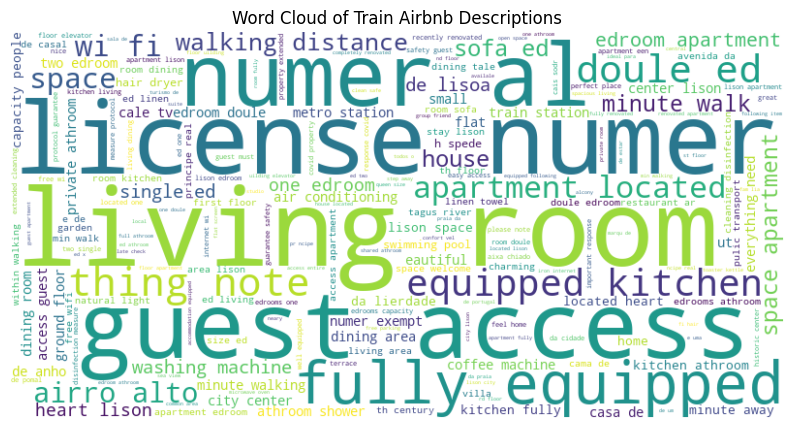

In [26]:
word_freq(clean_description, 'Word Cloud of Train Airbnb Descriptions')

__Notes:__ 

1. Word "wi-fi" is currently counted as words due to removal of symbols
2. "b" and "br" were removed because of HTML but it removed in all words

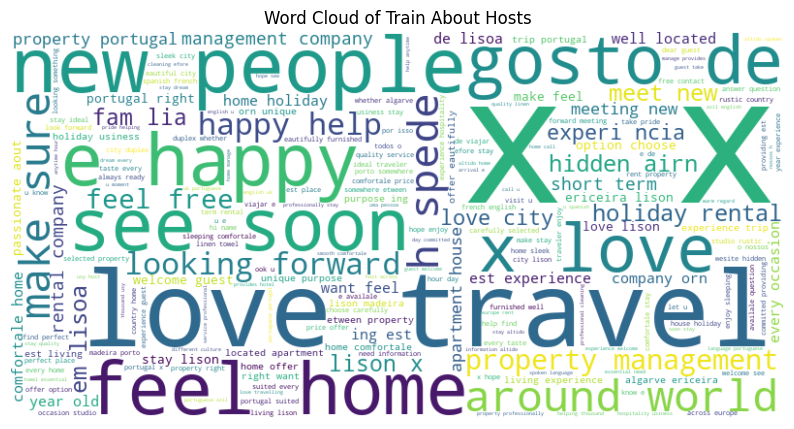

In [27]:
word_freq(clean_host, 'Word Cloud of Train About Hosts')

__Notes:__ 

1. Word "x" occurs multiple times and we noticed that it's used a lot of times when taling about measures like "1.80 m  x 2.00 m"
2. Any words with ponctuation like "família" become two words, in this case "fam" and "lia" with "í" removed

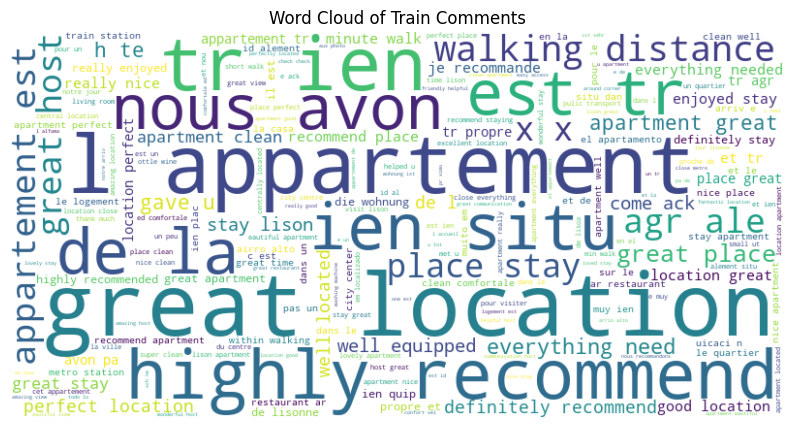

In [28]:
word_freq(clean_comments, 'Word Cloud of Train Comments')

__Notes:__ 

1. Same "b" and "br" problem
2. Also some "x" words
3. "tr" and "h" of HTML can be observed

### 1.7 Average comments per property & Number of distinct properties with comments

In [29]:
tmp = corpora_train_review.reset_index()['index'].value_counts()

tmp = pd.DataFrame({'index': tmp.index, 'count': tmp.values})

print(f'The properties in train data average {round(tmp["count"].mean())} comments')

The properties in train data average 85 comments


In [30]:
print(f'But the median is {round(tmp["count"].median())} comments')

But the median is 48 comments


In [31]:
import plotly.graph_objects as go

tmp = corpora_train_review.reset_index()['index'].value_counts()
tmp = pd.DataFrame({'index': tmp.index, 'count': tmp.values})

# Create the box plot
fig = go.Figure()
fig.add_trace(go.Box(x=tmp['count'], name='Count of Comments'))

# Update the layout
fig.update_layout(title='Distribution of Comments per Property',
                    yaxis_title='Number of Comments')

# Show the plot
fig.show()

__Notes:__

1. There are outliers that bias the average

---

In [32]:
# tmp is them temp df that contains all the distinct properties that have a comment
no_comment = round(( 1 - len(tmp) / len(corpora_train) ) * 100, 2)

print(f'{no_comment}% of the properties don\'t have a comment')

32.24% of the properties don't have a comment


In [33]:
tmp_2 = corpora_train.reset_index()
tmp_2 = tmp_2[~ tmp_2['index'].isin(tmp['index'] )]

# Calculate the percentages
unlist_percentages = tmp_2['unlisted'].value_counts(normalize=True) * 100

# Create the bar plot
fig = go.Figure(data=[go.Bar(x=unlist_percentages.values, y=unlist_percentages.index, orientation='h')])
fig.update_layout(title='Percentage of Unlisted Properties',
                    xaxis_title='Percentage',
                    yaxis_title='Unlisted',
                    bargap=0.5) 

# Add percentage labels to the bars
for i, percentage in enumerate(unlist_percentages.values):
    fig.add_annotation(x=percentage, y=unlist_percentages.index[i],
                        text=f"{percentage:.2f}%", showarrow=False,
                        font=dict(color='black'), xshift=1.2 * percentage)

fig.update_layout(showlegend=False)
fig.show()


__Notes:__

1. ~73% of the properties that don't have comments are unlisted, meaning not having a comment is a good indicator of whether the Airbnb is discarted or not
2. ~27% we believe they might be recent Airbnb's that didn't have the opportunity to generate reviews

---
## 2. Data Preprocessing 
Now that we observed some errors of our basic preprocess we'll try to fix them, the way to deal with html leftovers was not the best, only english stopwords are being used so irrelevant words from other languages are not being removed

__Preprocess consists on:__

* __Lowercase text__
> Converting everything to lowercase reducing vocabulary size

* __Remove Numerical Data and Punctuation__
> Normalize Dates and Numbers

* __Remove Stop Words__
> Removing words that are not very informative. Less tokens same meaning.

* __Lemmatize__
> Turning words into their root word

* __Stemmer__
> Remove last few characters to obtain the shorter form of each word, this one is setted to False in order to not perform.

***

In [34]:
emoji_sentiments = {
                    '✈️': 'Positive',
                    '🥳': 'Positive',
                    '🖤': 'Negative',
                    '☀️': 'Positive',
                    '🚕': 'Neutral',
                    '⭐': 'Positive',
                    '♥': 'Positive',
                    '🏡': 'Positive',
                    '🙌': 'Positive',
                    '🚇': 'Neutral',
                    '🤗': 'Positive',
                    '🚭': 'Negative',
                    '💓': 'Positive',
                    '🌴': 'Positive',
                    '🚗': 'Neutral',
                    '✔️': 'Positive',
                    '↗': 'Positive',
                    '😷': 'Negative',
                    '📍': 'Neutral',
                    '😎': 'Positive',
                    '🌿': 'Positive',
                    '😊': 'Positive',
                    '😂': 'Positive',
                    '☑️': 'Positive',
                    '⚠️': 'Negative',
                    '☀': 'Positive',
                    '➡': 'Neutral',
                    '▪': 'Neutral',
                    '☺': 'Positive',
                    '🚙': 'Neutral',
                    '➡️': 'Neutral',
                    '😶': 'Neutral',
                    '✅': 'Positive',
                    '😀': 'Positive',
                    '😉': 'Positive',
                    '☝': 'Positive',
                    '🏖️': 'Positive',
                    '⛱️': 'Positive',
                    '🌉': 'Neutral',
                    '❤️': 'Positive',
                    '🐕': 'Positive',
                    '💯': 'Positive',
                    '®': 'Neutral',
                    '📡': 'Neutral',
                    '🐶': 'Positive',
                    '❤': 'Positive',
                    '🙂': 'Positive',
                    '✔': 'Positive',
                    '💙': 'Positive',
                    '😘': 'Positive',
                    '🌷': 'Positive',
                    '✨': 'Positive',
                    '🎉': 'Positive',
                    '😄': 'Positive',
                    '☮️': 'Neutral',
                    '🎇': 'Positive',
                    '🌳': 'Positive',
                    '💃🏽': 'Positive',
                    "☮️": "Positive",
                    "🎇": "Positive",
                    "🌳": "Positive",
                    "💃🏽": "Positive",
                    "🐛": "Neutral",
                    "🤤": "Positive",
                    "🎖": "Positive",
                    "💣": "Negative",
                    "👞": "Neutral",
                    "🪳": "Neutral",
                    "🥞": "Positive",
                    "🌹": "Positive",
                    "🙋‍♂️": "Positive",
                    "🎷": "Positive",
                    "🫵🏽": "Neutral",
                    "👨‍👩‍👧‍👧": "Positive",
                    "💃": "Positive",
                    "😀": "Positive",
                    "📲": "Neutral",
                    "🤌🏿": "Neutral",
                    "🌊": "Positive",
                    "🌉": "Positive",
                    "💯": "Positive",
                    "➕": "Positive",
                    "📦": "Neutral",
                    "👐🏻": "Neutral",
                    "😖": "Negative",
                    "👣": "Neutral",
                    "⭐": "Positive",
                    "🤝🏻": "Positive",
                    "☔": "Neutral",
                    "👎🏽": "Negative",
                    "👻": "Neutral",
                    "🍀": "Positive",
                    "😐": "Neutral",
                    "🚶🏽‍♀️": "Neutral",
                    "🐩": "Positive",
                    "🐭": "Positive",
                    "👏🏽": "Positive",
                    "💪🏼": "Positive",
                    "🔝": "Positive",
                    "🏝": "Positive",
                    "🥲": "Positive",
                    "🙋‍♀️": "Positive",
                    "💥": "Positive",
                    "☕": "Positive",
                    "🧼": "Positive",
                    "👉🏼": "Positive",
                    "🎏": "Positive",
                    "👀": "Neutral",
                    "🚉": "Neutral",
                    "🤙🏾": "Positive",
                    "🎼": "Positive",
                    "🫶🏼": "Neutral",
                    "💝": "Positive",
                    "😨": "Negative",
                    "👪": "Positive",
                    "🤷🏻‍♀️": "Neutral",
                    "🌆": "Positive",
                    "🗻": "Neutral",
                    "😮": "Neutral",
                    "🚿": "Positive",
                    "🤌🏾": "Neutral",
                    "🤙🏻": "Positive",
                    "🫶🏽": "Neutral",
                    "🔑": "Positive",
                    "🌀": "Neutral",
                    "🙄": "Neutral",
                    "🧘‍♀️": "Positive",
                    "✌🏼": "Positive",
                    "🇫🇮": "Positive",
                    "🙌🏽": "Positive",
                    "🤙🏼": "Positive",
                    "☹": "Negative",
                    "🤕": "Negative",
                    "🇧🇷": "Positive",
                    "🏖": "Positive",
                    "🙈": "Positive",
                    "🤞🏼": "Positive",
                    "©": "Neutral",
                    "🤢": "Negative",
                    "✌🏿": "Positive",
                    "🤝🏼": "Positive",
                    "🧗‍♀️": "Positive",
                    "👮": "Neutral",
                    "🙏🏼": "Positive",
                    "🍒": "Positive",
                    "☹️": "Negative",
                    "🐝": "Positive",
                    "😊": "Positive",
                    "🍿": "Positive",
                    "🐸": "Neutral",
                    "🙏🏾": "Positive",
                    "🫶🏿": "Neutral",
                    "🏖️": "Positive",
                    "🍄": "Neutral",
                    "🙌🏿": "Positive",
                    "😶": "Neutral",
                    "🛴": "Positive",
                    "🌝": "Positive",
                    "🤵‍♂️": "Positive",
                    "😇": "Positive",
                    "🎀": "Positive",
                    "🤪": "Positive",
                    "😪": "Negative",
                    "☝️": "Positive",
                    "🤸‍♀️": "Positive",
                    "🇺🇸": "Positive",
                    "⚠️": "Negative",
                    "🚌": "Neutral",
                    "🦫": "Neutral",
                    "🚀": "Positive",
                    "🎊": "Positive",
                    "👌🏽": "Positive",
                    "🦋": "Positive",
                    "👫": "Positive",
                    "👋🏼": "Positive",
                    "❣": "Positive",
                    "😢": "Negative",
                    "😸": "Positive",
                    "💻": "Positive",
                    "🙇‍♀️": "Negative",
                    "🇮🇪": "Positive",
                    "🕊": "Positive",
                    "🙏": "Positive",
                    "⚫": "Neutral",
                    "😮‍💨": "Negative",
                    "🚤": "Positive",
                    "✈": "Positive",
                    "🌷": "Positive",
                    "🥴": "Negative",
                    "🐔": "Positive",
                    "🙌": "Positive",
                    "✅": "Positive",
                    "▪": "Neutral",
                    "💘": "Positive",
                    "🎒": "Positive",
                    "🌎": "Positive",
                    "😆": "Positive",
                    "🏴󠁧󠁢󠁷󠁬󠁳󠁿": "Positive",
                    "🉐": "Positive",
                    "🥣": "Positive",
                    "🫤": "Neutral",
                    "🎎": "Positive",
                    "😞": "Negative",
                    "💏": "Positive",
                    "🤌🏻": "Neutral",
                    "🍁": "Positive",
                    "🌟": "Positive",
                    "🏄‍♀️": "Positive",
                    "🤘": "Positive",
                    "🙁": "Negative",
                    "🎤": "Positive",
                    "🤛🏼": "Positive",
                    "🇨🇴": "Positive",
                    "✈️": "Positive",
                    "🌻": "Positive",
                    "🎻": "Positive",
                    "🇮🇹": "Positive",
                    "🌄": "Positive",
                    "🥧": "Positive",
                    "‼": "Positive",
                    "🏄‍♂️": "Positive",
                    "☺️": "Positive",
                    "📢": "Positive",
                    "👍🏿": "Positive",
                    "💦": "Positive",
                    "🔐": "Positive",
                    "✔️": "Positive",
                    "🙌🏾": "Positive",
                    "🙏🏻": "Positive",
                    "🫂": "Positive",
                    "💪🏻": "Positive",
                    "⬅️": "Negative",
                    "🚬": "Negative",
                    "😡": "Negative",
                    "🧽": "Positive",
                    "🖖": "Neutral",
                    "🧐": "Neutral",
                    "🇺🇦": "Positive",
                    "😩": "Negative",
                    "🏨": "Positive",
                    "🤗": "Positive",
                    "🟡": "Positive",
                    "❤️": "Positive",
                    "🕺": "Positive",
                    "🥇": "Positive",
                    "🤬": "Negative",
                    "✝️": "Positive",
                    "⛵": "Positive",
                    "🇷🇴": "Positive",
                    "✌️": "Positive",
                    "😋": "Positive",
                    "😂": "Positive",
                    "🍪": "Positive",
                    "🤓": "Positive",
                    "🤩": "Positive",
                    "🥶": "Negative",
                    "👏🏻": "Positive",
                    "💚": "Positive",
                    "🐣": "Positive",
                    "🏼": "Positive",
                    "🥹": "Negative"
                }

def replace_emojis_with_sentiments(text):
    for emoji in emoji_sentiments:
        if emoji in text:
            sentiment = emoji_sentiments[emoji]
            text = text.replace(emoji, sentiment)
    
    return text

In [35]:
# added more stopwords
stop = {
    'en': set(stopwords.words('english')),
    'fr': set(stopwords.words('french')),
    'pt': set(stopwords.words('portuguese')),
    'es': set(stopwords.words('spanish')),
    'de': set(stopwords.words('german')),
    'ru': set(stopwords.words('russian')),
    'it': set(stopwords.words('italian')),
    'nl': set(stopwords.words('dutch')),
    'zh-cn': set(stopwords.words('chinese')),
    'ro': set(stopwords.words('romanian')),
    'ca': set(stopwords.words('catalan')),
    'da': set(stopwords.words('danish'))
}

def pre_process(dataframe, text_list, lemmatize, stemmer):
    
    updates = []
    
    for idx, j in tqdm(enumerate(text_list)):
        
        if isinstance(j, str):
            
            try:
                language = dataframe['language'].iloc[idx]
            except: 
                try: 
                    language = dataframe['desc_language'].iloc[idx]
                except: 
                    language = dataframe['host_language'].iloc[idx]

            text = j
            
            # Replace emojis with sentiments 
            text = replace_emojis_with_sentiments(text)

            # Lowercase text
            text = text.lower()
            
            # Remove special characters and digits
            text = re.sub("[^a-zA-Z]", " ", text)
            text = re.sub("(\\d|\\W)+", " ", text)
            text = re.sub('[0-9]+', '', text)

            # replaced HTML with empty space
            text = re.sub(r'http\S+', ' ',text)

            # Remove tags
            text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
            
            # Remove stopwords
            try:
                text = " ".join([word for word in text.split() if word not in stop[language]])
            except: 
                pass

            # removes HTML isolated leftovers
            text = re.sub(r' br ', ' ',text)
            text = re.sub(r' tr ', ' ',text)
            text = re.sub(r' b ', ' ',text)
            text = re.sub(r' h ', ' ',text)

            # remove " x ", " l " and " d "
            text = re.sub(r' x ', ' ',text)
            text = re.sub(r' l ', ' ',text)
            text = re.sub(r' d ', ' ',text)
            text = re.sub(r' al ', ' ',text)
            
        else:
            text = np.nan
            
        # Lemmatize
        if lemmatize:
            if isinstance(j, str):
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())

                # removes HTML isolated leftovers (only after lemmatize process would make the removal complete)
                text = re.sub(r' br ', ' ',text)
                text = re.sub(r' tr ', ' ',text)
                text = re.sub(r' b ', ' ',text)
                text = re.sub(r' h ', ' ',text)

        # Stemming
        if stemmer:
            if isinstance(j, str):
                stemmer = SnowballStemmer('english')
                text = " ".join(stemmer.stem(word) for word in text.split())

                # removes HTML isolated leftovers (only after stemmer process would make the removal complete)
                text = re.sub(r' br ', ' ',text)
                text = re.sub(r' tr ', ' ',text)
                text = re.sub(r' b ', ' ',text)
                text = re.sub(r' h ', ' ',text)
            
        updates.append(text)
        
    return updates

__Validating preprocess__

0it [00:00, ?it/s]

12496it [00:03, 3754.07it/s]


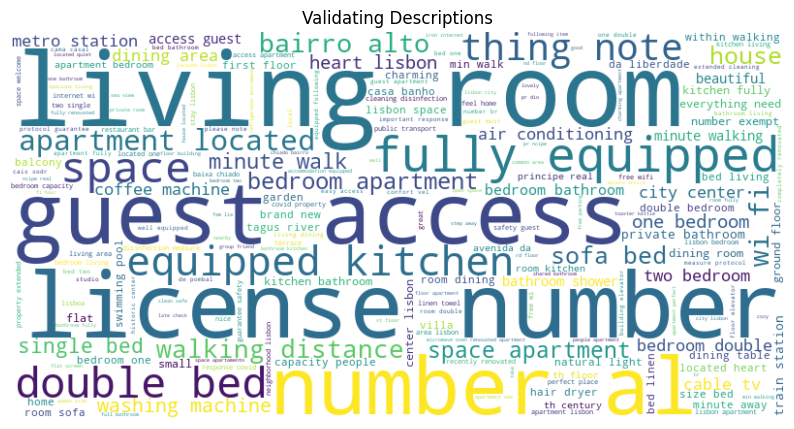

In [36]:
clean_description = pre_process(corpora_train, corpora_train['description'], lemmatize=True, stemmer=False)

word_freq(clean_description, 'Validating Descriptions')

12496it [00:01, 6722.15it/s]


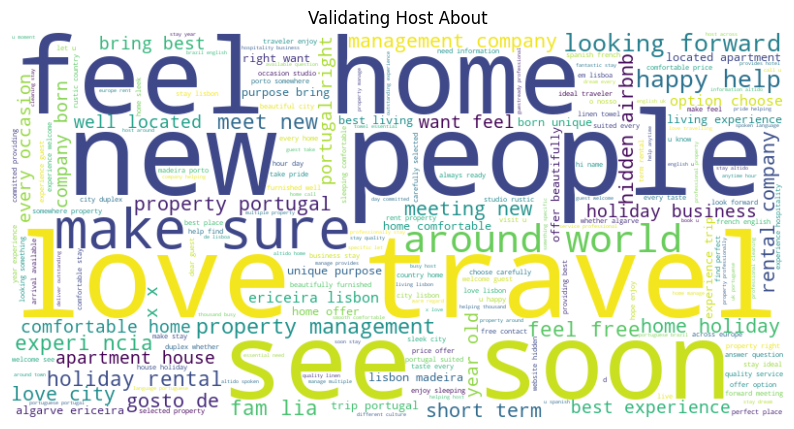

In [37]:
clean_host = pre_process(corpora_train, corpora_train['host_about'], lemmatize=True, stemmer=False)

word_freq(clean_host, 'Validating Host About')

721402it [01:06, 10887.27it/s]


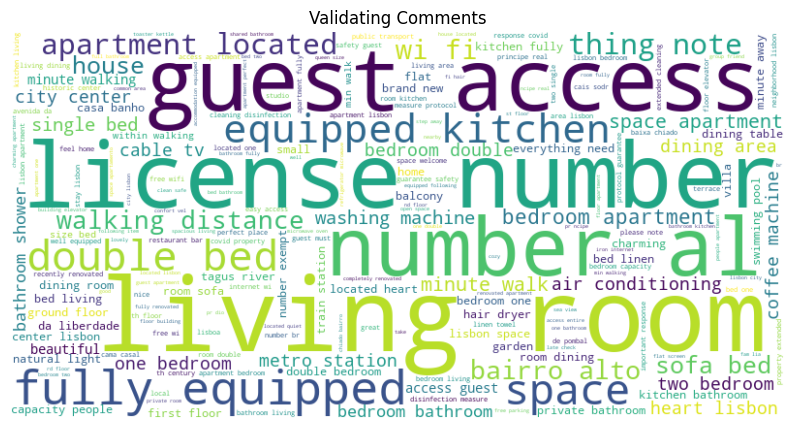

In [38]:
clean_comment = pre_process(corpora_train_review, corpora_train_review['comments'], lemmatize=True, stemmer=False)

word_freq(clean_description, 'Validating Comments')

__Final Validation__
> Normal example

In [39]:
corpora_train['description'].iloc[0]

'This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and  There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!<br /><br /><b>Guest access</b><br />All rooms have key-card access.'

In [40]:
clean_description[0]

'shared mixed room hostel shared bathroom located right across street subway station parque min walk marque de pombal square space offer woman room mixed room double room twin room single room family room kitchen open guest lounge guest gather cable tv room come standard equipped comfortable bed linen blanket reading lamp side table free wi fi access guest curfew access late check sleep late guest access room key card access'

> Emoji example

In [41]:
corpora_train['description'].iloc[9763]

"✅ 2 Bedroom Apartment on a First Floor  <br />✅ Central & Quiet Location   <br />✅ Completely Renovated and Fully Equipped with AC <br />✅ Outside Terrace Area   <br />✅ Perfect for Couples and Families <br /> <br />The Estrela apartment is a spacious and comfortable place located in one of the most scenic areas of Lisbon. If you are looking for a typical, popular, and more upscale neighborhood in Lisbon, then this is the perfect apartment for you! It's proximity to the city center, combined with the charm of the Estrela neighborhood makes it a much sought after location! <br /> <br />We're here to help you with making the most out of your stay. Let us know if you have any questions or special requests!<br /><br /><b>The space</b><br />Bright refurbished apartment in Estrela, near to everything you will need to make your stay memorable! <br /> <br />»Two Bedrooms (1 double; 1 twin) <br /> <br />»Flat-screen TV with Satellite Channels <br /> <br />»Fully Equipped Kitchen with a Dishwas

In [42]:
clean_description[9763]

'positive bedroom apartment first floor positive central quiet location positive completely renovated fully equipped ac positive outside terrace area positive perfect couple family estrela apartment spacious comfortable place located one scenic area lisbon looking typical popular upscale neighborhood lisbon perfect apartment proximity city center combined charm estrela neighborhood make much sought location help making stay let u know question special request space bright refurbished apartment estrela near everything need make stay memorable two bedroom double twin flat screen tv satellite channel fully equipped kitchen dishwash'

---

Applying on test

In [43]:
# Data Pre Processing saved into columns
corpora_train['description_clean'] = clean_description
corpora_train['host_about_clean'] = clean_host
corpora_train_review['comments_clean'] = clean_comment

# Drop missing values of train reviews
corpora_train_review = corpora_train_review.dropna()

In [44]:
# creating language columns for test sets
# creating new column with language sufixes
corpora_test['desc_language']=corpora_test.description.apply(detect_textlang)
corpora_test['host_language']=corpora_test.host_about.apply(detect_textlang)
corpora_test_review['language']=corpora_test_review.comments.apply(detect_textlang)

# Aplying preprocess on test and saving into columns
corpora_test['description_clean'] = pre_process(corpora_test, corpora_test['description'], lemmatize=True, stemmer=False)
corpora_test['host_about_clean'] = pre_process(corpora_test, corpora_test['host_about'], lemmatize=True, stemmer=False)
corpora_test_review['comments_clean'] = pre_process(corpora_test_review, corpora_test_review['comments'], lemmatize=True, stemmer=False)

1389it [00:00, 3985.43it/s]
1389it [00:00, 6548.12it/s]
80877it [00:07, 10960.04it/s]


1. Were created new features according to each column in each file.

2. New Features regard a sufix in their name as __`"_clean"`__.

3. The new features regard the new data already __Tokenized__ (process of splitting a text into individual words or tokens), in __Lowercase__ (no Uppercase Letters), __without special characters, digits, tags and stopwords__ and __Lemmatized__ (word in their root word). 

## __3. Feature Engineering__
* description of the methods implemented (accounts for 25% of
criteria 4.3)

* The oject in study will be file __`"corpora_train"`__ which is the one that will be used for model train

* Feature Importance 
    > Term Frequency 
    
    TF = (Number of times the word appears in the document) / (Total number of words in the document)

    > Inverse Doc. Frequency

    IDF = log((Total number of documents in the corpus) / (Number of documents containing the word))

### __3.1 Splitting Data__

In [45]:
X_desc = corpora_train['description_clean']
X_host = corpora_train['host_about_clean']

y = corpora_train['unlisted']

# Setting random states seed
seed = 0

# Splitting the data, leaving 20% in the hold out sample
X_train_desc, X_test_desc, _, _ = train_test_split(
                                                    X_desc,
                                                    y,
                                                    random_state = seed,
                                                    shuffle = True,
                                                    stratify = y,
                                                    test_size = .2,
                                                )

X_train_host, X_test_host, y_train, y_test = train_test_split(
                                                    X_host,
                                                    y,
                                                    random_state = seed,
                                                    shuffle = True,
                                                    stratify = y,
                                                    test_size = .2,
                                                )

del _

In [46]:
print('train: {}% - {} Individuals \ntest: {}% - {} Individuals'.format(
                                                                round(len(y_train)/len(y)*100),
                                                                len(y_train),
                                                                round(len(y_test)/len(y)*100),
                                                                len(y_test)
                                                                ))

train: 80% - 9996 Individuals 
test: 20% - 2500 Individuals


### __3.2 TF-IDF__

* Vectorization of information, in x_train and x_test to train the models

In [47]:

languages = {
    'en': 'english',
    'fr': 'french',
    'pt': 'portuguese',
    'es': 'spanish',
    'de': 'german',
    'ru': 'russian',
    'it': 'italian',
    'nl': 'dutch',
    'zh-cn': 'chinese',
    'ro': 'romanian',
    'ca': 'catalan',
    'da': 'danish'
}


tfidf = TfidfVectorizer(
                        sublinear_tf=True, # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
                        analyzer='word',
                        ngram_range=(1,3), # The lower and upper boundary of the range of n-values for different n-grams (allowing trigrams currently)
                        max_features=5000, 
                        stop_words= list(languages.values())
                        )

X_train_desc_tfidf = tfidf.fit_transform(X_train_desc).toarray()
X_test_desc_tfidf = tfidf.transform(X_test_desc).toarray()
X_train_host_tfidf = tfidf.fit_transform(X_train_host).toarray()
X_test_host_tfidf = tfidf.transform(X_test_host).toarray()

In [48]:
print(f'Example of TF-IDF {X_train_desc_tfidf[:1]}')

Example of TF-IDF [[0. 0. 0. ... 0. 0. 0.]]


### __3.3 GloVe Words Embedding__

In [49]:
a = input('Have you downloaded GloVe folder? (y : yes, n : no)')

while a != 'y' and a != 'n': 
    a = input('Have you downloaded GloVe folder? (y : yes, n : no)')

# Current path
current_path = os.getcwd()


if a == 'n':
    # URL for the GloVe word embeddings file
    url = "http://nlp.stanford.edu/data/glove.6B.zip"

    # Name of the zip
    filename = "glove.6B.zip"

    # Downloading GloVe 
    urllib.request.urlretrieve(url, filename)

    print('Downloaded')

    zip_path = os.path.join(current_path, 'glove.6B.zip')

    output_folder = os.path.join(current_path, 'glove.6B')

    # Unzipping
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

    print('Unzipped')

del a

# File path
glove_path = os.path.join(current_path, 'glove.6B/glove.6B.200d.txt')


In [50]:
def load_word_embeddings(file=glove_path):
    embeddings = {}
    # Opening file on read mode w/utf-8 encoding
    with open(file, 'r', encoding='utf-8') as infile:
        for line in infile:
            # Separate each line into separate values
            values = line.split()

            # Saving words as keys and embeddings vector as value in embeddings dict
            embeddings[values[0]] = np.asarray(values[1:], dtype='float32')

    return embeddings

# Loading GloVe word embeddings
glove_embeddings = load_word_embeddings()

In [51]:
list(glove_embeddings.keys())[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [52]:
def sentence_features_v2(s, embeddings=glove_embeddings,emb_size=200):
    # ignore stop words
    words=s
    words=[w for w in words if w.isalpha() and w in embeddings]

    # If there are no valid words returns a zero vector
    if len(words)==0:
        return np.hstack([np.zeros(emb_size)])

    # If there are the returns an array of word embeddings for valid words
    M=np.array([embeddings[w] for w in words])

    # Mean of word embeddings row-wise
    return M.mean(axis=0)

In [53]:
X_train_desc_glove = np.array([sentence_features_v2(x) for x in X_train_desc])
X_test_desc_glove = np.array([sentence_features_v2(x) for x in X_test_desc])
X_train_host_glove = np.array([sentence_features_v2(x) for x in X_train_host])
X_test_host_glove = np.array([sentence_features_v2(x) for x in X_test_host])

In [54]:
print(f'Example of GloVe Embedding {X_train_desc_glove[:1]}')

Example of GloVe Embedding [[ 8.79401416e-02  5.52821457e-01 -2.32193500e-01 -4.04171050e-02
  -1.03401402e-02 -2.90203810e-01 -1.97893620e-01 -2.02478081e-01
  -5.11302948e-01 -1.54121742e-01 -4.37788844e-01  1.23393752e-01
   9.03464034e-02  8.10822174e-02  4.45369244e-01 -2.07591861e-01
  -3.39469522e-01  1.88312754e-02 -2.26589411e-01 -3.10417384e-01
   6.62851473e-03  1.53402424e+00 -3.69718283e-01  7.50274286e-02
   4.96057212e-01 -2.87669361e-01 -2.88680732e-01  1.19809307e-01
   1.09492652e-01  4.50119436e-01 -1.39280260e-01  3.72415751e-01
  -4.05460536e-01 -4.01807100e-01 -5.83920404e-02 -1.32015109e-01
  -2.09757984e-01 -3.34496528e-01 -1.71533927e-01 -1.83496699e-02
  -3.56549859e-01 -6.55896142e-02  1.97786689e-02  2.12711602e-01
  -2.61888504e-01 -1.04997694e-01  4.90741342e-01 -4.03584749e-01
   2.33806632e-02 -2.35673591e-01  3.16076219e-01  1.65033787e-02
   1.99806392e-01  1.44460097e-01  2.71932721e-01  1.68805987e-01
  -1.43502489e-01  1.25327110e-01  6.83614239e-02

### __3.4 mBERT Word Embedding__

In [58]:
# Load pre-trained mBERT tokenizer and model
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
mbert_model = BertModel.from_pretrained('bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [96]:
def mbert_embedding(data, batch_size=32):
    max_seq_length = 512  # Maximum sequence length
    
    mbert_desc_embeddings = []
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        
        batch_desc_embeddings = []
        for desc in batch:
            # Tokenize the description
            mbert_desc_tokens = mbert_tokenizer.tokenize(desc)
            
            # Truncate tokens if necessary
            if len(mbert_desc_tokens) > max_seq_length - 2:
                mbert_desc_tokens = mbert_desc_tokens[:max_seq_length-2]
            
            # Add special tokens [CLS] and [SEP]
            mbert_desc_tokens = ['[CLS]'] + mbert_desc_tokens + ['[SEP]']
            
            # Convert tokens to token IDs
            mbert_desc_token_ids = mbert_tokenizer.convert_tokens_to_ids(mbert_desc_tokens)
            
            # Convert token IDs to tensors
            mbert_desc_input_ids = torch.tensor([mbert_desc_token_ids])
            
            # Obtain mBERT word embeddings for the description
            with torch.no_grad():
                mbert_desc_outputs = mbert_model(mbert_desc_input_ids)
                mbert_desc_word_embeddings = mbert_desc_outputs.last_hidden_state
            
            # Average the word embeddings over the sequence length
            mbert_desc_word_embeddings_avg = torch.mean(mbert_desc_word_embeddings, dim=1)
            
            # Convert the tensor to a numpy array and append to the batch embeddings
            mbert_desc_word_embeddings_avg = mbert_desc_word_embeddings_avg.numpy()
            mbert_desc_word_embeddings_avg = np.reshape(mbert_desc_word_embeddings_avg, -1)
            batch_desc_embeddings.append(mbert_desc_word_embeddings_avg)
        
        # Append the batch embeddings to the overall embeddings
        mbert_desc_embeddings.extend(batch_desc_embeddings)

    return np.array(mbert_desc_embeddings)

In [97]:
X_train_desc_mbert = mbert_embedding(X_train_desc)
X_test_desc_mbert = mbert_embedding(X_test_desc)
X_train_host_mbert = mbert_embedding(X_train_host)
X_test_host_mbert = mbert_embedding(X_test_host)

In [102]:
print(f'Example of mBERT Word Embedding {X_train_desc_mbert[:1]}')  

Example of mBERT Word Embedding [[-2.07894340e-01 -1.12674482e-01  1.56638697e-01  1.88163280e-01
  -1.87142745e-01 -3.31727505e-01 -6.90893680e-02 -1.16284497e-01
   2.17983037e-01 -7.90856630e-02 -5.91727912e-01  1.39194474e-01
  -4.50228512e-01  3.91552523e-02  3.15629005e-01 -2.13309422e-01
  -1.70743853e-01  7.39992559e-02  5.81416525e-02 -1.80768251e-01
  -4.44918156e-01 -2.18859091e-01 -2.22207084e-01  8.61002207e-02
  -2.43029490e-01 -2.54839242e-01  2.89625168e-01  1.16735086e-01
   4.90635931e-01  2.66699612e-01  1.98506027e-01 -1.62684500e-01
   6.63981959e-02 -4.46324766e-01 -4.98109534e-02 -1.21553570e-01
  -3.51882637e-01  5.04179478e-01 -3.99731934e-01 -7.93601722e-02
   4.82662678e-01  1.69413745e-01 -2.77692750e-02 -2.15893760e-02
   1.44607469e-01  1.94690838e-01 -3.56534589e-03 -3.38500679e-01
   3.37035149e-01 -3.76579165e-03 -8.84086788e-02 -2.46812567e-01
  -5.25025070e-01 -4.40997243e-01  3.40308398e-02 -2.04058155e-01
   2.18477994e-01 -6.62029386e-02 -6.3493102

### __3.5 FasText Word Embedding__

In [63]:
# FastText model
fasttext_model = FastText(
                            sentences=X_train_desc, # input data
                            vector_size=300, # dimensionality of the word vectors(embeddings)
                            window=5, # Maximum distance between the current and predicted word within a sentence
                            min_count=1, # Min frequeency count of words
                            workers=4, # Number of workers threads to be used for trainin. CPU
                            sg=1 # 1 = skip-gram will be used, 0 = would use CBOW (continuous Bag of Words alg.)
                            ) 

X_train_desc_fast = np.array([fasttext_model.wv[x] for x in X_train_desc])

fasttext_model = FastText(
                            sentences=X_test_desc, # input data
                            vector_size=300, # dimensionality of the word vectors(embeddings)
                            window=5, # Maximum distance between the current and predicted word within a sentence
                            min_count=1, # Min frequeency count of words
                            workers=4, # Number of workers threads to be used for trainin. CPU
                            sg=1 # 1 = skip-gram will be used, 0 = would use CBOW (continuous Bag of Words alg.)
                            ) 

X_test_desc_fast = np.array([fasttext_model.wv[x] for x in X_test_desc])

fasttext_model = FastText(
                            sentences=X_train_host, # input data
                            vector_size=300, # dimensionality of the word vectors(embeddings)
                            window=5, # Maximum distance between the current and predicted word within a sentence
                            min_count=1, # Min frequeency count of words
                            workers=4, # Number of workers threads to be used for trainin. CPU
                            sg=1 # 1 = skip-gram will be used, 0 = would use CBOW (continuous Bag of Words alg.)
                            ) 

X_train_host_fast = np.array([fasttext_model.wv[x] for x in X_train_host])

fasttext_model = FastText(
                            sentences=X_test_host, # input data
                            vector_size=300, # dimensionality of the word vectors(embeddings)
                            window=5, # Maximum distance between the current and predicted word within a sentence
                            min_count=1, # Min frequeency count of words
                            workers=4, # Number of workers threads to be used for trainin. CPU
                            sg=1 # 1 = skip-gram will be used, 0 = would use CBOW (continuous Bag of Words alg.)
                            ) 

X_test_host_fast = np.array([fasttext_model.wv[x] for x in X_test_host])

In [64]:
print(f'Example of FasText Embedding {X_train_desc_fast[:1]}')

Example of FasText Embedding [[ 9.54555871e-05  2.99849744e-05 -8.72495730e-05  4.03137055e-05
   7.49713654e-05  6.66756023e-05  2.11689130e-05  8.25409916e-06
   8.94232799e-05 -6.49396170e-05  1.24921178e-04  3.11564290e-05
  -2.17297566e-05 -4.17967658e-06 -4.38053939e-06  1.31470415e-05
  -2.65065846e-05 -1.54580193e-05 -5.28342935e-05 -3.27767812e-05
   1.24470523e-06 -4.32031229e-05  2.15669370e-05  2.06480654e-05
   1.14476609e-06 -3.53644427e-05  4.68510079e-05  8.53917518e-05
  -1.48548308e-04  1.79962772e-05 -3.24537068e-05 -1.35066402e-05
   5.33564962e-05 -4.61837772e-05  3.12131815e-05  4.61436248e-05
  -8.46244620e-06 -5.56016348e-05 -3.04940786e-05 -1.02248450e-05
   2.50880566e-05  2.74159302e-05  5.31688747e-05 -2.68828226e-05
   8.92614044e-05 -2.88111660e-05  5.81968561e-05  2.01420371e-05
  -5.31311634e-05  1.36435949e-04  6.21352883e-05  1.74618508e-05
  -4.43002245e-05  6.51950540e-05  2.07596149e-05 -2.39709607e-05
  -1.39237954e-05  2.09611444e-05 -7.16662616e-

## 4. "Descripiton" and "Host About" Classification Based Models 

In [ ]:
def model_base(X_train_vect, X_test_vect, plot=False):

    # tools
    shape = X_train_vect.shape[1] 
    class_dict = {0: class_weight.iloc[0], 1: class_weight.iloc[1]}

    # Setting models seed for reproducibility
    seed = 0

    # Define the LSTM model architecture
    model_lstm = Sequential()
    model_lstm.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(None, shape)))
    model_lstm.add(Dense(units=64, activation='relu'))
    model_lstm.add(Dense(units=1, activation='sigmoid'))  # Assuming binary classification, adjust the number of units for multi-class

    # Reshape the input data for LSTM
    X_train_vect_lstm = np.expand_dims(X_train_vect, axis=1)

    # Compile the model
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Creating base classifiers' instance
    LR_model = LogisticRegression(random_state=seed, class_weight=class_dict).fit(X_train_vect, y_train) # Logistic Regression
    KNN_model = KNeighborsClassifier(n_neighbors=15, metric = 'cosine', weights = 'distance').fit(X_train_vect, y_train) # K-Nearest Neighbors
    MLP_model = MLPClassifier(random_state=seed, solver='adam', hidden_layer_sizes=(2,2), activation='logistic').fit(X_train_vect, y_train) # Multi Layer Perceptron
    LSTM_model = model_lstm.fit(X_train_vect_lstm, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.20) # Long Short Term Memory

    # all base models list
    models = [
        LR_model,
        KNN_model,
        MLP_model,
        LSTM_model,
        ]

    # creating list of models names
    model_str = [str(model) for model in models] # getting model raw names
    # formating names
    model_str = [model.split('(', 1)[0] for model in model_str]
    model_name = [' '.join(re.findall('[A-Z][^A-Z]*', model)) for model in model_str]

    model_name[-1] = 'LSTM'

    # creating dataframe for results
    df = pd.DataFrame(columns = ['Model', 'F1-Score', 'Accuracy', 'Precision', 'Recall', 'AUC'])
        
    for model, name in zip(models, model_name):

        if type(model) == keras.callbacks.History:            
            f1 = np.nan
            accuracy = LSTM_model.history['val_binary_accuracy'][-1]
            precision = np.nan
            recall = np.nan
            roc = np.nan
        else:
            instance = model  # instance model
            y_pred = instance.predict(X_test_vect)  # raw data prediction
            # benchmark metrics
            f1 = f1_score(y_test, y_pred, average='micro')
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='micro')
            recall = recall_score(y_test, y_pred, average='micro')
            roc = metrics.roc_auc_score(y_test, y_pred)

        # adding row with model name and respective metrics
        df.loc[name] = [name, f1, accuracy, precision, recall, roc]
        
        if plot:

            if type(model) == keras.callbacks.History:
                plt.figure(figsize =(10, 6))
                plt.plot(LSTM_model.history['binary_accuracy'])
                plt.plot(LSTM_model.history['val_binary_accuracy'])
                plt.title('Model Accuracy')
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')
                plt.legend(['train', 'val'], loc='upper left')
                plt.show()
            else:
                classification_r = classification_report(y_test, y_pred)
                
                print('Model {}\n\n'.format(model))
                print('Classification Report:\n{}'.format(classification_r))

                # Confusion Matrix code:
                cm = confusion_matrix(y_pred, y_test)
                
                group_names = ['True Neg','False Pos','False Neg','True Pos']

                group_counts = ["{0:0.0f}".format(value) for value in
                                cm.flatten()]

                group_percentages = ["{0:.2%}".format(value) for value in
                                    cm.flatten()/np.sum(cm)]

                labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                        zip(group_names,group_counts,group_percentages)]

                labels = np.asarray(labels).reshape(2,2)

                ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

                ax.set_title('Confusion Matrix\n\n')
                ax.set_xlabel('\nPredicted Values')
                ax.set_ylabel('Actual Values ')

                ## Ticket labels - List must be in alphabetical order
                ax.xaxis.set_ticklabels(['False','True'])
                ax.yaxis.set_ticklabels(['False','True'])

                ## Display the visualization of the Confusion Matrix.
                plt.show()
                
                # Roc curve

                fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
                #create ROC curve
                plt.plot(fpr,tpr,label="AUC="+str(roc))
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.xticks(color='black')
                plt.yticks(color='black')
                plt.title('Gradient Boosting Roc Curve',fontsize = 20, fontweight = 'bold')
                plt.legend(loc=4)
                plt.show()
            
    # sorting by the F1-score
    df.sort_values(by='Accuracy', ascending=False, inplace=True)
    # setting Model names as index
    df.set_index('Model', inplace=True)

    
    return df

### 4.1 Description

> TF-IDF

In [106]:
# checking best base models          
base_model = model_base(X_train_desc_tfidf, X_test_desc_tfidf, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.777200,0.777200,0.777200,0.777200,0.644828
Logistic Regression,0.768000,0.768000,0.768000,0.768000,0.642022
M L P Classifier,0.752000,0.752000,0.752000,0.752000,0.673655
LSTM,nan,0.734000,nan,nan,nan


> GloVe

In [107]:
# checking best base models          
base_model = model_base(X_train_desc_glove, X_test_desc_glove, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.760000,0.760000,0.760000,0.760000,0.595567
LSTM,nan,0.725000,nan,nan,nan
Logistic Regression,0.723600,0.723600,0.723600,0.723600,0.501443
M L P Classifier,0.722800,0.722800,0.722800,0.722800,0.500000


> mBERT

In [108]:
# checking best base models          
base_model = model_base(X_train_desc_mbert, X_test_desc_mbert, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.767600,0.767600,0.767600,0.767600,0.628846
LSTM,nan,0.752500,nan,nan,nan
Logistic Regression,0.742800,0.742800,0.742800,0.742800,0.548974
M L P Classifier,0.738800,0.738800,0.738800,0.738800,0.594690


> FasText

In [109]:
# checking best base models          
base_model = model_base(X_train_desc_fast, X_test_desc_fast, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.777600,0.777600,0.777600,0.777600,0.632206
LSTM,nan,0.725000,nan,nan,nan
Logistic Regression,0.722800,0.722800,0.722800,0.722800,0.500000
M L P Classifier,0.722800,0.722800,0.722800,0.722800,0.500000


### 4.2 Host About

> TF-IDF

In [110]:
# checking best base models          
base_model = model_base(X_train_host_tfidf, X_test_host_tfidf, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.789600,0.789600,0.789600,0.789600,0.702334
Logistic Regression,0.784000,0.784000,0.784000,0.784000,0.647308
M L P Classifier,0.774800,0.774800,0.774800,0.774800,0.680086
LSTM,nan,0.767500,nan,nan,nan


> GloVe

In [111]:
# checking best base models          
base_model = model_base(X_train_host_glove, X_test_host_glove, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.783600,0.783600,0.783600,0.783600,0.699073
LSTM,nan,0.725500,nan,nan,nan
Logistic Regression,0.724400,0.724400,0.724400,0.724400,0.502886
M L P Classifier,0.722800,0.722800,0.722800,0.722800,0.500000


> mBERT

In [112]:
# checking best base models          
base_model = model_base(X_train_host_mbert, X_test_host_mbert, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.793200,0.793200,0.793200,0.793200,0.681250
LSTM,nan,0.768000,nan,nan,nan
M L P Classifier,0.762800,0.762800,0.762800,0.762800,0.629529
Logistic Regression,0.749600,0.749600,0.749600,0.749600,0.566133


> FasText

In [113]:
# checking best base models          
base_model = model_base(X_train_host_fast, X_test_host_fast, plot=False)

base_model.style

,F1-Score,Accuracy,Precision,Recall,AUC
Model,,,,,
K Neighbors Classifier,0.789600,0.789600,0.789600,0.789600,0.688100
LSTM,nan,0.724500,nan,nan,nan
Logistic Regression,0.722800,0.722800,0.722800,0.722800,0.500000
M L P Classifier,0.722800,0.722800,0.722800,0.722800,0.500000


### 4.3 Description & Host About Final Models

KNN with 15 neighbors, cosine metric and distance as weights, seem to have the best results among the models tested on both `Description` and `Host About` models. So they'll be the models choosen to advance. Regarding word embedding methods, the ones who performed better were: 

1. Description: __TF-IDF__
2. Host_About: __mBERT__

The first phase of this chapter is to evalueate and the second to perform the final models on full training set

> Description Results

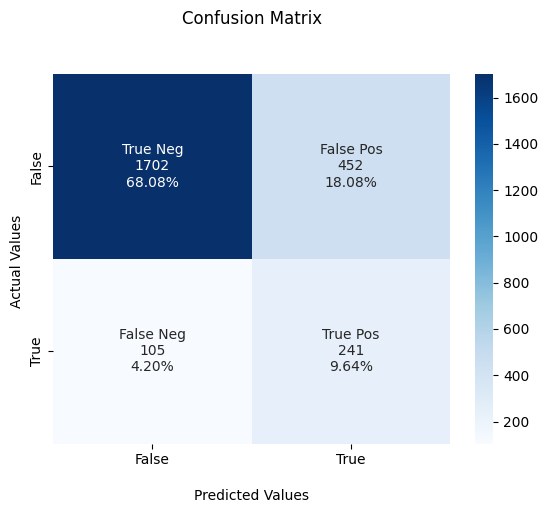

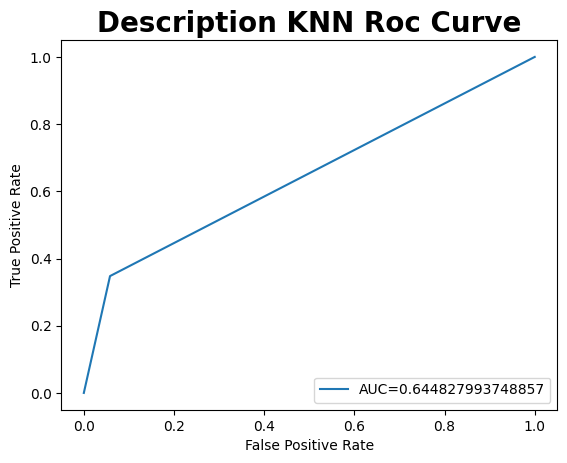

In [354]:
KNN_model_desc = KNeighborsClassifier(n_neighbors=15, metric = 'cosine', weights = 'distance')

# Description with TF-IDF data
KNN_model_desc.fit(X_train_desc_tfidf, y_train)

y_pred = KNN_model_desc.predict(X_test_desc_tfidf)  

# benchmark metrics
f1 = metrics.f1_score(y_test, y_pred, average='micro')
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='micro')
recall = metrics.recall_score(y_test, y_pred, average='micro')
roc = metrics.roc_auc_score(y_test, y_pred)
                
# Confusion Matrix code:
cm = confusion_matrix(y_pred, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Roc curve

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Description KNN Roc Curve',fontsize = 20, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

__Notes:__

1. Descriptions alone don't predict really well the unlisted values.

> Host About

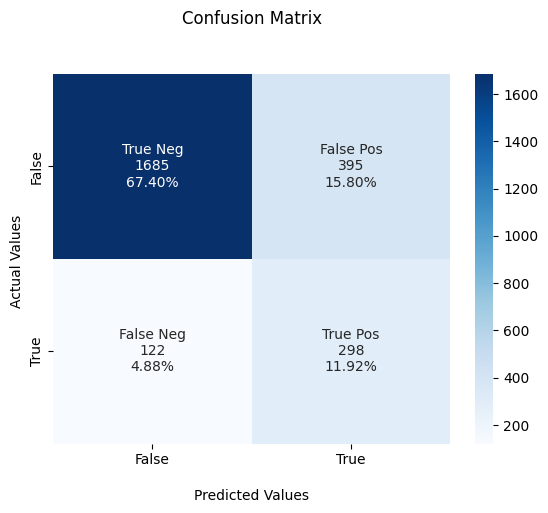

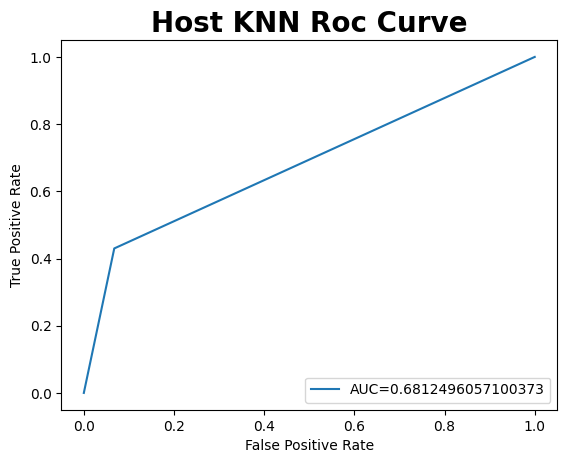

In [355]:
KNN_model_host = KNeighborsClassifier(n_neighbors=15, metric = 'cosine', weights = 'distance')

# Description with TF-IDF data
KNN_model_host.fit(X_train_host_mbert, y_train)

y_pred = KNN_model_host.predict(X_test_host_mbert)  

# benchmark metrics
f1 = f1_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
roc = metrics.roc_auc_score(y_test, y_pred)
                
# Confusion Matrix code:
cm = confusion_matrix(y_pred, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Roc curve

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Host KNN Roc Curve',fontsize = 20, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

__Notes:__

1. Host About Model seem to be a better predictor for unlisted than Description Model

__Models on full trainings set__

In [ ]:
# embeddings on full
X_desc_tfidf = tfidf.fit_transform(X_desc).toarray()
X_host_mbert = mbert_embedding(X_host)

In [172]:
desc_propbs = KNN_model_desc.predict_proba(X_desc_tfidf)
host_probs = KNN_model_host.predict_proba(X_host_mbert)

In [177]:
corpora_train['desc_prob_0'] = desc_propbs[:, 0]
corpora_train['desc_prob_1'] = desc_propbs[:, 1]
corpora_train['host_prob_0'] = host_probs[:, 0]
corpora_train['host_prob_1'] = host_probs[:, 1]

corpora_train.head()

,description,host_about,unlisted,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1
index,,,,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,shared mixed room hostel shared bathroom locat...,alojamento local registro al,0.734337,0.265663,1.0,1.510743e-07
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,espa fica perto parque eduardo vii saldanha es...,i am friendly host and i will try to always be...,0.590021,0.409979,0.0,1.000000e+00
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,0.662657,0.337343,0.5,5.000000e-01
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en,apartamento charmoso chiado largo carmo traves...,hello i m portuguese and i love to meet people...,0.735110,0.264890,1.0,0.000000e+00
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,joli appartement bordure mer min a pied plage ...,famille deux enfants an habit pendant plusieur...,0.667354,0.332646,1.0,0.000000e+00


## 5. Sentiment Analysis 

A unsupervised sentiment analysis was performed mBERT on the comments in another workspace, the averages per property to merge with `corpora_train`. 

This sentiment analysis was made based on 10 random reviews per property because it was very computationally expensive.

### 5.1 Merging Data & Feature Engineering

In [121]:
sentiment = pd.read_csv('Comments_SA_avg.csv', index_col=0)

sentiment.head()

,avg_sentiment_score
index,
1,4.0
5,4.7
8,4.9
9,4.9
10,4.2


In [178]:
# merging dataframes
corpora_train = corpora_train.merge(sentiment, left_index=True, right_index=True, how='left')

corpora_train.head()

,description,host_about,unlisted,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1,avg_sentiment_score
index,,,,,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,shared mixed room hostel shared bathroom locat...,alojamento local registro al,0.734337,0.265663,1.0,1.510743e-07,4.0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,espa fica perto parque eduardo vii saldanha es...,i am friendly host and i will try to always be...,0.590021,0.409979,0.0,1.000000e+00,NaN
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,0.662657,0.337343,0.5,5.000000e-01,NaN
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en,apartamento charmoso chiado largo carmo traves...,hello i m portuguese and i love to meet people...,0.735110,0.264890,1.0,0.000000e+00,NaN
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,joli appartement bordure mer min a pied plage ...,famille deux enfants an habit pendant plusieur...,0.667354,0.332646,1.0,0.000000e+00,4.7


__Notes:__

1. It's observable missing values on the properties without reviews, we'll fill missing values with 1.5 so they get a penalty

In [179]:
# filling missing values of properties without reviews with penalization
corpora_train['avg_sentiment_score'].fillna(1.5, inplace=True)

In [180]:
# creating number of reviews column
corpora_train = corpora_train.merge(tmp.set_index('index'), left_index=True, right_index=True, how='left').rename({'count':'n_reviews'}, axis=1)
corpora_train['n_reviews'].fillna(0, inplace=True)
corpora_train.head()

,description,host_about,unlisted,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1,avg_sentiment_score,n_reviews
index,,,,,,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,shared mixed room hostel shared bathroom locat...,alojamento local registro al,0.734337,0.265663,1.0,1.510743e-07,4.0,50.0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,espa fica perto parque eduardo vii saldanha es...,i am friendly host and i will try to always be...,0.590021,0.409979,0.0,1.000000e+00,1.5,0.0
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,0.662657,0.337343,0.5,5.000000e-01,1.5,0.0
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en,apartamento charmoso chiado largo carmo traves...,hello i m portuguese and i love to meet people...,0.735110,0.264890,1.0,0.000000e+00,1.5,0.0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,joli appartement bordure mer min a pied plage ...,famille deux enfants an habit pendant plusieur...,0.667354,0.332646,1.0,0.000000e+00,4.7,41.0


### 5.2 Normalizing Data

In [181]:
cols_to_norm = ['avg_sentiment_score', 'n_reviews']

# Normalizing data
scaler = MinMaxScaler()
corpora_train_normalized = corpora_train.copy()
corpora_train_normalized[cols_to_norm] = scaler.fit_transform(corpora_train[cols_to_norm])

# Create new DataFrame with normalized columns
corpora_train = corpora_train_normalized.copy()

corpora_train.head()


,description,host_about,unlisted,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1,avg_sentiment_score,n_reviews
index,,,,,,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,shared mixed room hostel shared bathroom locat...,alojamento local registro al,0.734337,0.265663,1.0,1.510743e-07,0.750,0.042553
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,espa fica perto parque eduardo vii saldanha es...,i am friendly host and i will try to always be...,0.590021,0.409979,0.0,1.000000e+00,0.125,0.000000
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,0.662657,0.337343,0.5,5.000000e-01,0.125,0.000000
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en,apartamento charmoso chiado largo carmo traves...,hello i m portuguese and i love to meet people...,0.735110,0.264890,1.0,0.000000e+00,0.125,0.000000
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,joli appartement bordure mer min a pied plage ...,famille deux enfants an habit pendant plusieur...,0.667354,0.332646,1.0,0.000000e+00,0.925,0.034894


## 6. Final Models

### Manual Model

Based on Pearson correlation to define weights to the columns on the following columns:

1. `desc_prob_1` (could be desc_prob_0 because they're the inverse of each other)
2. `host_prob_1` (could be host_prob_0 because they're the inverse of each other)
3. `avg_sentiment_score`

In [242]:
correlation_1 = abs(corpora_train['unlisted'].corr(corpora_train['desc_prob_1']))
correlation_2 = abs(corpora_train['unlisted'].corr(corpora_train['host_prob_1']))
correlation_3 = abs(corpora_train['unlisted'].corr(corpora_train['avg_sentiment_score']))

corr = [correlation_1, correlation_2, correlation_3]

val = sum(corr)

normalized_corr = [x/val for x in corr]

# Final weights
normalized_corr

[0.22445399326529342, 0.4119472633718667, 0.3635987433628398]

In [235]:
corpora_train['manual_pred'] = corpora_train.apply(lambda row: 1 if round((row['desc_prob_1'] * normalized_corr[0]) + (row['host_prob_1'] * normalized_corr[1]) + (row['avg_sentiment_score'] * normalized_corr[2]), 2) >= 0.5 else 0, axis=1)

In [241]:
corpora_train[['manual_pred', 'unlisted']].head(5)

,manual_pred,unlisted
index,,
1,0,0
2,1,1
3,0,1
4,0,0
5,0,0


In [363]:
# Assuming 'true_labels' column contains the true label
manual_pred = corpora_train['manual_pred']
unlisted = corpora_train['unlisted']

print("F1 score for 'manual_pred':", f1_manual_pred)

classification_r = classification_report(unlisted, manual_pred)

print(classification_r)

F1 score for 'manual_pred': 0.5760594795539032
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9033
           1       0.59      0.56      0.58      3463

    accuracy                           0.77     12496
   macro avg       0.71      0.71      0.71     12496
weighted avg       0.77      0.77      0.77     12496



__Random Forest__

In [300]:
X = corpora_train[['desc_prob_1', 'host_prob_1', 'avg_sentiment_score']]
y = corpora_train['unlisted']

# Splitting the data, leaving 20% in the hold out sample
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    random_state = 0,
                                                    shuffle = True,
                                                    stratify = y,
                                                    test_size = .2,
                                                )

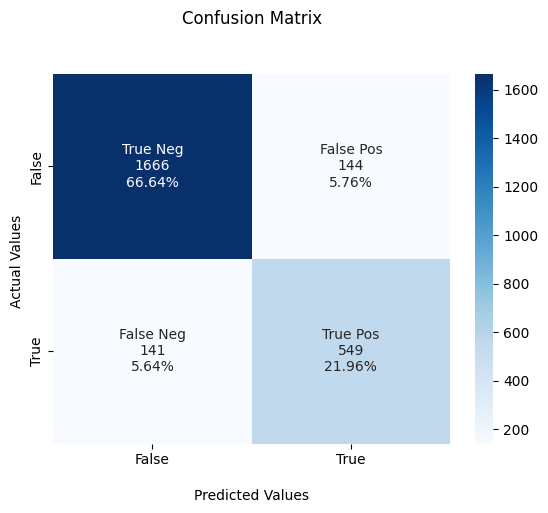

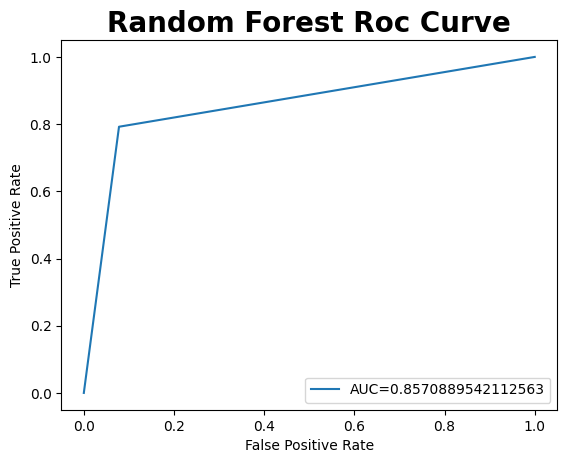

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1807
           1       0.80      0.79      0.79       693

    accuracy                           0.89      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500

F1-Score: 0.886


In [364]:
class_dict = {0: class_weight.iloc[0], 1: class_weight.iloc[1]}

# Create the Random Forest classifier
random_forest = RandomForestClassifier(random_state=0, criterion = 'entropy',
                                max_depth = 5,
                                min_samples_split = 2,
                                max_features = 'auto',
                                bootstrap = False,
                                oob_score = False,
                                warm_start = False,
                                class_weight = 'balanced',
                                min_samples_leaf = 1,
                                n_estimators=250,
                                )

# Train the classifier on the entire dataset
random_forest.fit(X_train, y_train)

# Predict the labels for the same dataset
y_pred = random_forest.predict(X_test)
                
# Confusion Matrix code:
cm = confusion_matrix(y_pred, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Roc curve
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
roc = auc(fpr, tpr)

f1 = f1_score(y_test, y_pred, average='micro')

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Random Forest Roc Curve',fontsize = 20, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

classification_r = classification_report(y_test, y_pred)

print(classification_r)
print(f'F1-Score: {f1}')


__XGBoost__

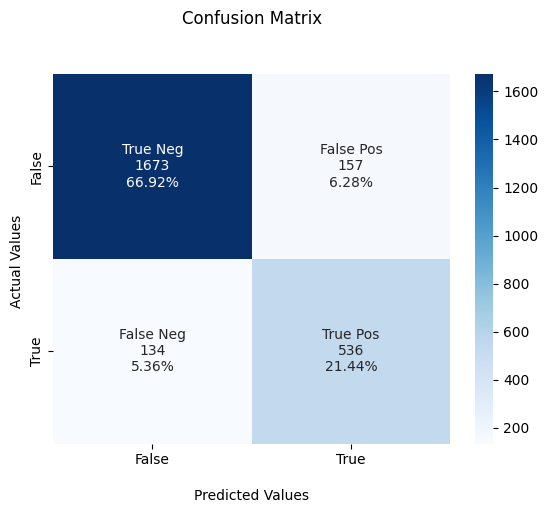

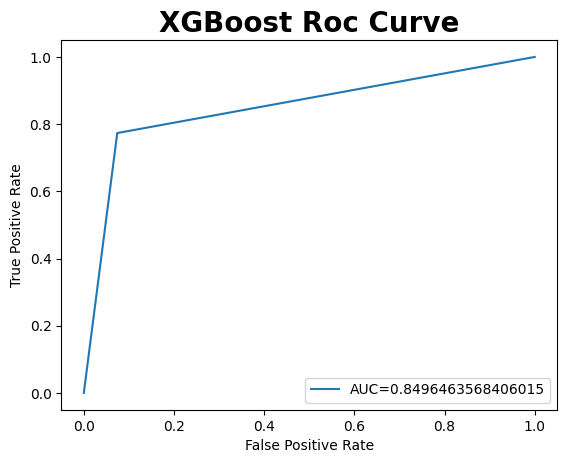

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1807
           1       0.80      0.77      0.79       693

    accuracy                           0.88      2500
   macro avg       0.86      0.85      0.85      2500
weighted avg       0.88      0.88      0.88      2500

F1-Score: 0.8836


In [365]:
# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(  objective="binary:logistic",
                                        booster="gbtree",
                                        n_estimators=100,
                                        learning_rate=0.01,
                                        max_depth=3,
                                        min_child_weight=1,
                                        subsample=1,
                                        colsample_bytree=1,
                                        gamma=0,
                                        reg_alpha=0,
                                        reg_lambda=1,
                                        scale_pos_weight=1,
                                        random_state=0)

# Train the classifier on the entire dataset
xgb_classifier.fit(X_train, y_train)

# Predict the labels for the same dataset
y_pred = xgb_classifier.predict(X_test)
                
# Confusion Matrix code:
cm = confusion_matrix(y_pred, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Roc curve
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
roc = auc(fpr, tpr)

f1 = f1_score(y_test, y_pred, average='micro')

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('XGBoost Roc Curve',fontsize = 20, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

classification_r = classification_report(y_test, y_pred)

print(classification_r)
print(f'F1-Score: {f1}')

__KNN__

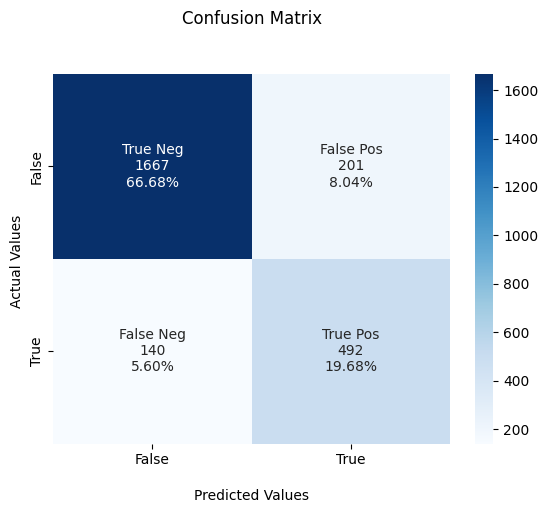

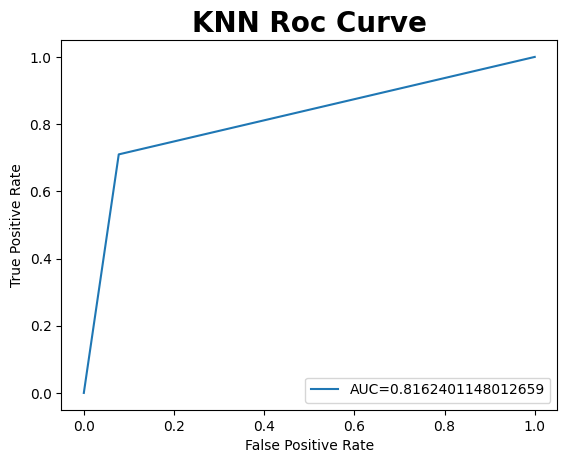

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1807
           1       0.78      0.71      0.74       693

    accuracy                           0.86      2500
   macro avg       0.84      0.82      0.82      2500
weighted avg       0.86      0.86      0.86      2500

F1-Score: 0.8636


In [366]:
# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=20, metric = 'cosine', weights='distance', p=1)

# Train the classifier on the entire dataset
knn.fit(X_train, y_train)

# Predict the labels for the same dataset
y_pred = knn.predict(X_test)

# Confusion Matrix code:
cm = confusion_matrix(y_pred, y_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Roc curve
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
roc = auc(fpr, tpr)

f1 = f1_score(y_test, y_pred, average='micro')

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('KNN Roc Curve',fontsize = 20, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

classification_r = classification_report(y_test, y_pred)

print(classification_r)
print(f'F1-Score: {f1}')


__Notes:__ 

1. KNN seems to have the best performance among the four final models, therefore it'll be the one implemented in test data.

## 7. Predicting on Test Data

### Process Test

In [294]:
desc = corpora_test['description_clean']
host = corpora_test['host_about_clean']

# embeddings on test
desc_tfidf = tfidf.fit_transform(desc).toarray()
host_mbert = mbert_embedding(host)

In [297]:
desc_propbs = KNN_model_desc.predict_proba(desc_tfidf)
host_probs = KNN_model_host.predict_proba(host_mbert)

corpora_test['desc_prob_0'] = desc_propbs[:, 0]
corpora_test['desc_prob_1'] = desc_propbs[:, 1]
corpora_test['host_prob_0'] = host_probs[:, 0]
corpora_test['host_prob_1'] = host_probs[:, 1]

In [299]:
corpora_test

,description,host_about,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1
index,,,,,,,,,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",en,pt,b space apartment located historic center lisb...,gosto de viajar de conhecer pessoas gosto de r...,0.731915,0.268085,1.000000,0.000000e+00
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,en,en,important response covid property extended cle...,home team count u take care every single detai...,1.000000,0.000000,1.000000,4.100197e-07
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",en,en,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,0.662162,0.337838,0.800000,2.000000e-01
4,Charming Apartment Close to the Bay of Cascais...,:),en,NA,charming apartment close bay cascais bedroom d...,,0.533401,0.466599,0.866667,1.333333e-01
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,pt,pt,procura uma f rias perto praia casino outras a...,bem vindos portugal adoro pa s tamb m adoro co...,0.931573,0.068427,0.742325,2.576750e-01
...,...,...,...,...,...,...,...,...,...,...
1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,pt,en,melhor ponto partida descobrir lisboa junto av...,i work in hospitality and i love traveling pho...,0.664637,0.335363,0.000000,1.000000e+00
1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",en,en,casa de baixo cozy comfortable apartment ideal...,visit u stay u discover beautiful city world l...,0.797303,0.202697,1.000000,0.000000e+00
1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",en,en,beautiful peaceful apartment superb view minim...,nice well travelled educated cult cosmopolitan...,1.000000,0.000000,0.602817,3.971834e-01


In [369]:
sentiment_test = pd.read_csv('Comments_SA_test_avg.csv', index_col=0)

sentiment_test.head()

,avg_sentiment_score
index,
1,4.5
2,4.3
4,4.8
5,4.4
6,4.8


In [375]:
# merging dataframes
corpora_test = corpora_test.merge(sentiment_test, left_index=True, right_index=True, how='left')

# filling missing values of properties without reviews with penalization
corpora_test['avg_sentiment_score'].fillna(1.5, inplace=True)

cols_to_norm = ['avg_sentiment_score']

# Normalizing data
scaler = MinMaxScaler()
corpora_test_normalized = corpora_test.copy()
corpora_test_normalized[cols_to_norm] = scaler.fit_transform(corpora_test[cols_to_norm])

# Create new DataFrame with normalized columns
corpora_test = corpora_test_normalized.copy()

corpora_test.head()


,description,host_about,desc_language,host_language,description_clean,host_about_clean,desc_prob_0,desc_prob_1,host_prob_0,host_prob_1,avg_sentiment_score
index,,,,,,,,,,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",en,pt,b space apartment located historic center lisb...,gosto de viajar de conhecer pessoas gosto de r...,0.731915,0.268085,1.000000,0.000000e+00,0.875
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,en,en,important response covid property extended cle...,home team count u take care every single detai...,1.000000,0.000000,1.000000,4.100197e-07,0.825
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",en,en,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,0.662162,0.337838,0.800000,2.000000e-01,0.125
4,Charming Apartment Close to the Bay of Cascais...,:),en,NA,charming apartment close bay cascais bedroom d...,,0.533401,0.466599,0.866667,1.333333e-01,0.950
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,pt,pt,procura uma f rias perto praia casino outras a...,bem vindos portugal adoro pa s tamb m adoro co...,0.931573,0.068427,0.742325,2.576750e-01,0.850


In [376]:
X = corpora_test[['desc_prob_1', 'host_prob_1', 'avg_sentiment_score']]

# Predict the labels for test
y_pred = random_forest.predict(X)

In [382]:
pd.DataFrame(corpora_test.reset_index()['index'])

,index
0,1
1,2
2,3
3,4
4,5
...,...
1384,1385
1385,1386
1386,1387
1387,1388


In [386]:
final = pd.DataFrame(corpora_test.reset_index()['index']).rename({'index':'ids'},axis=1)

final['pred'] = y_pred

final.head(10)

,ids,pred
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [388]:
# final predicted labels percentage
final.pred.value_counts(normalize=True)

pred
0    0.712023
1    0.287977
Name: proportion, dtype: float64

In [389]:
# train labels percentage
class_weight

unlisted
0    72.287132
1    27.712868
Name: count, dtype: float64

In [ ]:
final.to_csv('Predictions_47.csv')